# Investigate a potential blob bump on mainnet
See .env.example to set the environment variables.

In [50]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn imageio > /dev/null 2>&1

In [51]:
import dotenv
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio

dotenv.load_dotenv()

# Load and display config
start_date = os.getenv('START_DATE_TIME')
if not start_date:
    raise ValueError("START_DATE_TIME environment variable is required")

end_date = os.getenv('END_DATE_TIME')
if not end_date:
    end_date = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")

network = os.getenv('NETWORK')

print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

# Convert start and end dates to datetime objects
try:
    start_dt = datetime.fromisoformat(start_date.replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid start date format. Date must be in ISO format. Error: {str(e)}")

try:
    if isinstance(end_date, datetime):
        end_dt = end_date
    else:
        end_dt = datetime.fromisoformat(str(end_date).replace("Z", "+00:00"))
except ValueError as e:
    raise ValueError(f"Invalid end date format. Date must be in ISO format. Error: {str(e)}")

# Calculate the difference in hours
hours = (end_dt - start_dt).total_seconds() / 3600

print(f"hours: {hours}")


start_date: 2024-10-04T22:00:00Z
end_date: 2024-11-25T16:10:14Z
hours: 1242.1705555555557


In [8]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine, text

engine = create_engine(db_url)

connection = engine.connect()

In [11]:
# Query for MEV relay delivered slots
block_query = text("""
    SELECT DISTINCT
        slot
    FROM mev_relay_proposer_payload_delivered FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    ORDER BY slot ASC
""")

result = connection.execute(block_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
mev_slots = pd.DataFrame(result.fetchall(), columns=['slot'])

print(mev_slots)

            slot
0       10104599
1       10104600
2       10104601
3       10104602
4       10104603
...          ...
338562  10474055
338563  10474056
338564  10474057
338565  10474060
338566  10474061

[338567 rows x 1 columns]


In [12]:
# Query for all slots in time window
all_slots_query = text("""
    SELECT DISTINCT
        slot,
        slot_start_date_time as time
    FROM beacon_api_eth_v1_events_block FINAL 
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    ORDER BY slot ASC
""")

result = connection.execute(all_slots_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
all_slots = pd.DataFrame(result.fetchall(), columns=['slot', 'time'])

print(all_slots)


            slot                time
0       10104599 2024-10-04 22:00:11
1       10104600 2024-10-04 22:00:23
2       10104601 2024-10-04 22:00:35
3       10104602 2024-10-04 22:00:47
4       10104603 2024-10-04 22:00:59
...          ...                 ...
368251  10474058 2024-11-25 05:31:59
368252  10474059 2024-11-25 05:32:11
368253  10474060 2024-11-25 05:32:23
368254  10474061 2024-11-25 05:32:35
368255  10474062 2024-11-25 05:32:47

[368256 rows x 2 columns]


Total slots: 368256
Total MEV slots: 338567


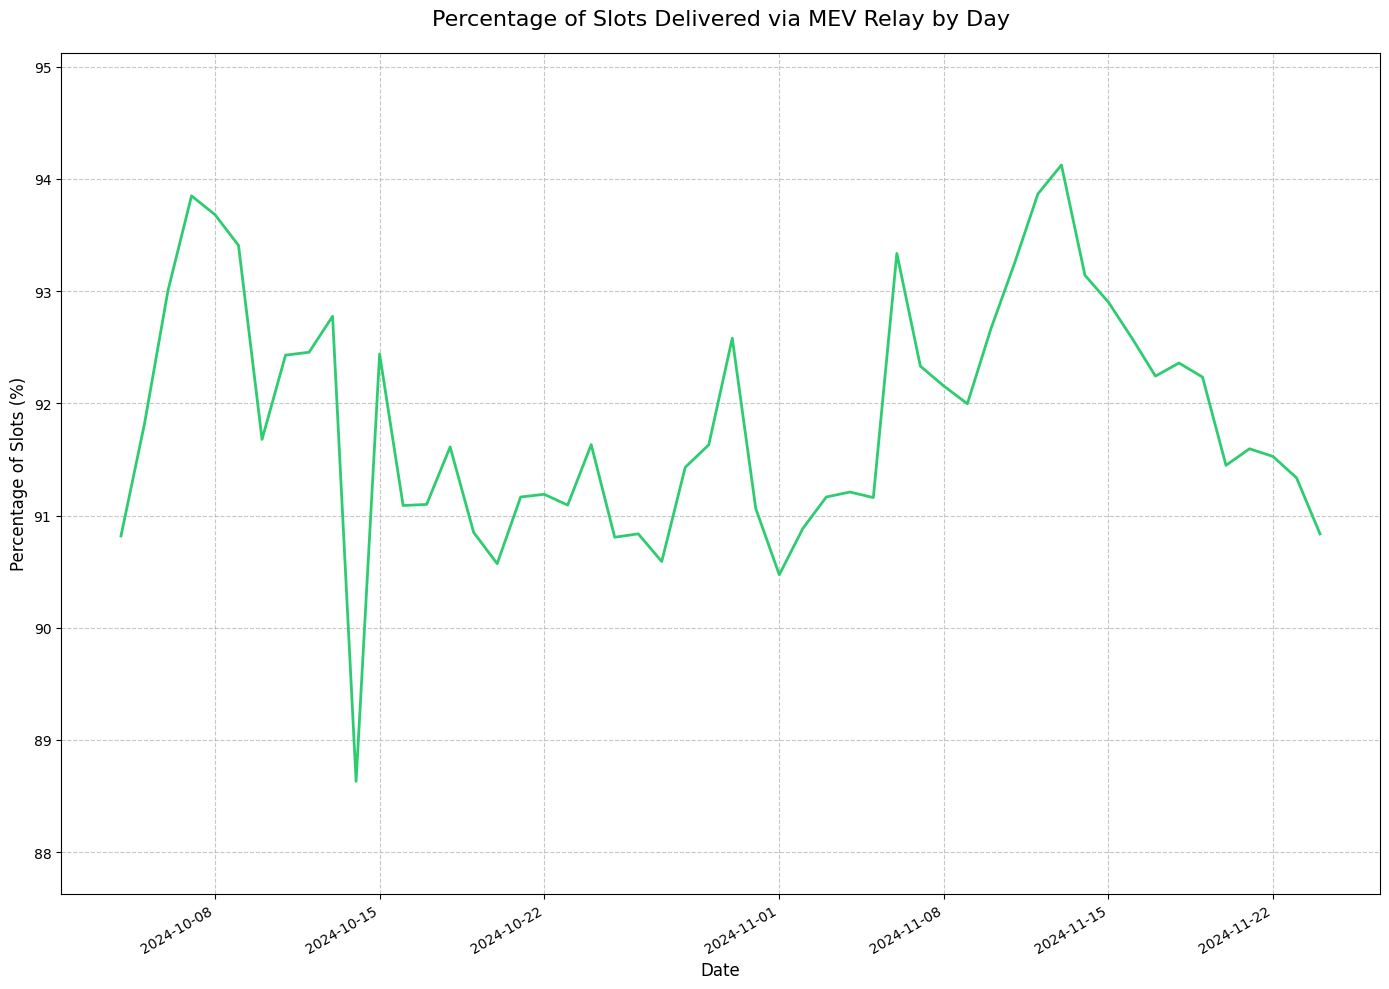

In [13]:
total_slots = len(all_slots)
total_mev_slots = len(mev_slots)

print(f"Total slots: {total_slots}")
print(f"Total MEV slots: {total_mev_slots}")

# Convert time to datetime and set as index
all_slots['time'] = pd.to_datetime(all_slots['time'])
mev_slots_with_time = pd.merge(mev_slots.copy(), all_slots[['slot', 'time']], on='slot', how='left')
mev_slots_with_time['time'] = pd.to_datetime(mev_slots_with_time['time'])

# Filter out last 5000 slots since they are probably incomplete
max_slot = all_slots['slot'].max() - 5000
mev_slots_filtered = mev_slots_with_time[mev_slots_with_time['slot'] <= max_slot]
all_slots_filtered = all_slots[all_slots['slot'] <= max_slot]

# Resample by day
mev_daily = mev_slots_filtered.resample('D', on='time').size()
all_daily = all_slots_filtered.resample('D', on='time').size()

# Calculate percentage per day
daily_percentage = (mev_daily / all_daily) * 100

# Create figure
plt.figure(figsize=(14, 10))

# Create line plot
plt.plot(daily_percentage.index, daily_percentage.values, color='#2ecc71', linewidth=2)

# Customize plot
plt.title('Percentage of Slots Delivered via MEV Relay by Day', pad=20, fontsize=16)
plt.ylabel('Percentage of Slots (%)', fontsize=12)
plt.xlabel('Date', fontsize=12)

# Set y-axis limits with some padding
y_min = max(0, daily_percentage.min() - 1)
y_max = min(100, daily_percentage.max() + 1)
plt.ylim(y_min, y_max)

# Format dates nicely
plt.gcf().autofmt_xdate()

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [14]:
# Get non-MEV slots by filtering out MEV slots
non_mev_slots = all_slots[~all_slots['slot'].isin(mev_slots['slot'])]

print(non_mev_slots)
print(f"found {len(non_mev_slots)} non-MEV slots")


            slot                time
11      10104610 2024-10-04 22:02:23
14      10104613 2024-10-04 22:02:59
18      10104617 2024-10-04 22:03:47
22      10104621 2024-10-04 22:04:35
29      10104628 2024-10-04 22:05:59
...          ...                 ...
368241  10474048 2024-11-25 05:29:59
368246  10474053 2024-11-25 05:30:59
368251  10474058 2024-11-25 05:31:59
368252  10474059 2024-11-25 05:32:11
368255  10474062 2024-11-25 05:32:47

[29871 rows x 2 columns]
found 29871 non-MEV slots


In [20]:
# Query to get block sizes for all slots
block_sizes_query = text("""
    SELECT 
        slot,
        block_total_bytes_compressed,
        slot_start_date_time as time,
        proposer_index
    FROM canonical_beacon_block
    WHERE 
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
""")
block_sizes = pd.DataFrame(
    connection.execute(block_sizes_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'block_total_bytes_compressed', 'time', 'proposer_index']
)

# Get proposer entities
proposer_query = text("""
    SELECT 
        `index` as proposer_index,
        entity
    FROM ethseer_validator_entity
    WHERE 
        meta_network_name = 'mainnet'
""")
proposer_entities = pd.DataFrame(
    connection.execute(proposer_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['proposer_index', 'entity']
)

# Get blob sidecar data for our slots
blob_sidecars_query = text("""
    SELECT 
        slot,
        COUNT(*) as num_blobs,
        SUM(blob_size) as total_blob_size
    FROM canonical_beacon_blob_sidecar FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_network_name = 'mainnet'
    GROUP BY slot, toDate(slot_start_date_time)
""")
blob_sidecars = pd.DataFrame(
    connection.execute(blob_sidecars_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')}).fetchall(),
    columns=['slot', 'num_blobs', 'total_blob_size']
)

# Convert blob_sidecars to a dictionary
blob_sidecars_map = blob_sidecars.set_index('slot').to_dict(orient='index')

# Build combined data using block_sizes as the canonical list of slots
combined_data = block_sizes.copy()
combined_data = combined_data.merge(proposer_entities, on='proposer_index', how='left')
combined_data['num_blobs'] = combined_data['slot'].map(lambda slot: blob_sidecars_map.get(slot, {'num_blobs': 0})['num_blobs'])
combined_data['total_blob_size'] = combined_data['slot'].map(lambda slot: blob_sidecars_map.get(slot, {'total_blob_size': 0})['total_blob_size'])

# Calculate total data per slot
combined_data['total_data_per_slot'] = combined_data['block_total_bytes_compressed'] + combined_data['total_blob_size']


combined_data['block_pct'] = combined_data['block_total_bytes_compressed'] / combined_data['total_data_per_slot'] * 100
combined_data['blob_pct'] = combined_data['total_blob_size'] / combined_data['total_data_per_slot'] * 100

# Add 'via_mev' column to combined_data
combined_data['via_mev'] = combined_data['slot'].isin(mev_slots['slot'])
combined_data['date'] = pd.to_datetime(combined_data['time']).dt.date

print(combined_data)


            slot  block_total_bytes_compressed                time  \
0       10299584                         59934 2024-10-31 23:57:11   
1       10299587                         51448 2024-10-31 23:57:47   
2       10299588                         44171 2024-10-31 23:57:59   
3       10299589                         30616 2024-10-31 23:58:11   
4       10299590                         63124 2024-10-31 23:58:23   
...          ...                           ...                 ...   
366527  10299573                         35127 2024-10-31 23:54:59   
366528  10299576                         45288 2024-10-31 23:55:35   
366529  10299577                         38160 2024-10-31 23:55:47   
366530  10299578                         56183 2024-10-31 23:55:59   
366531  10299583                         34955 2024-10-31 23:56:59   

        proposer_index            entity  num_blobs  total_blob_size  \
0              1591324               NaN          0                0   
1              

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_88498/1438580768.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mev_slots_with_sizes['date'] = pd.to_datetime(mev_slots_with_sizes['time']).dt.date
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_88498/1438580768.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mev_slots_with_sizes['date'] = pd.to_datetime(non_mev_slots_with_sizes['time']).dt.date


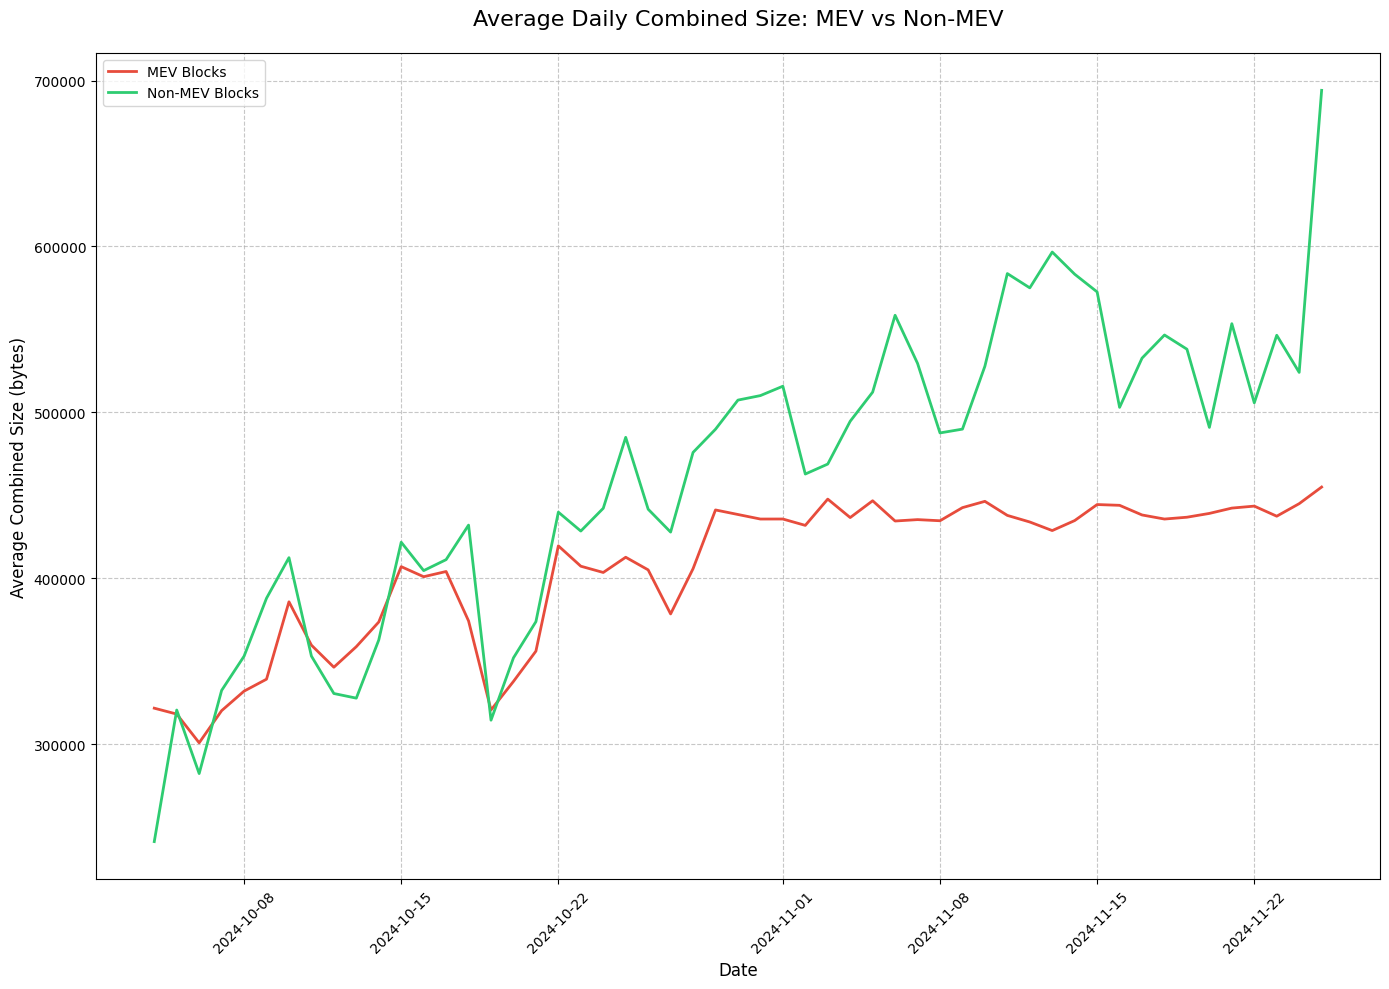

In [19]:
# Split combined_data into MEV and non-MEV dataframes
mev_slots_with_sizes = combined_data[combined_data['via_mev']]
non_mev_slots_with_sizes = combined_data[~combined_data['via_mev']]

# Convert time to date
mev_slots_with_sizes['date'] = pd.to_datetime(mev_slots_with_sizes['time']).dt.date
non_mev_slots_with_sizes['date'] = pd.to_datetime(non_mev_slots_with_sizes['time']).dt.date

# Calculate daily averages using combined size
mev_daily_avg = mev_slots_with_sizes.groupby('date')['total_data_per_slot'].mean()
non_mev_daily_avg = non_mev_slots_with_sizes.groupby('date')['total_data_per_slot'].mean()

# Create figure
plt.figure(figsize=(14, 10))

# Plot daily averages
plt.plot(mev_daily_avg.index, mev_daily_avg.values, color='#e74c3c', label='MEV Blocks', linewidth=2)
plt.plot(non_mev_daily_avg.index, non_mev_daily_avg.values, color='#2ecc71', label='Non-MEV Blocks', linewidth=2)

plt.title('Average Daily Combined Size: MEV vs Non-MEV', pad=20, fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Combined Size (bytes)', fontsize=12)
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_88498/986758385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mev_data['block_pct'] = non_mev_data['block_total_bytes_compressed'] / non_mev_data['total_data_per_slot'] * 100
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_88498/986758385.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mev_data['blob_pct'] = non_mev_data['total_blob_size'] / non_mev_data['total_data_per_slot'] * 100
/var/folders/fq/bp58gxy12nd2b32pw1y8wy

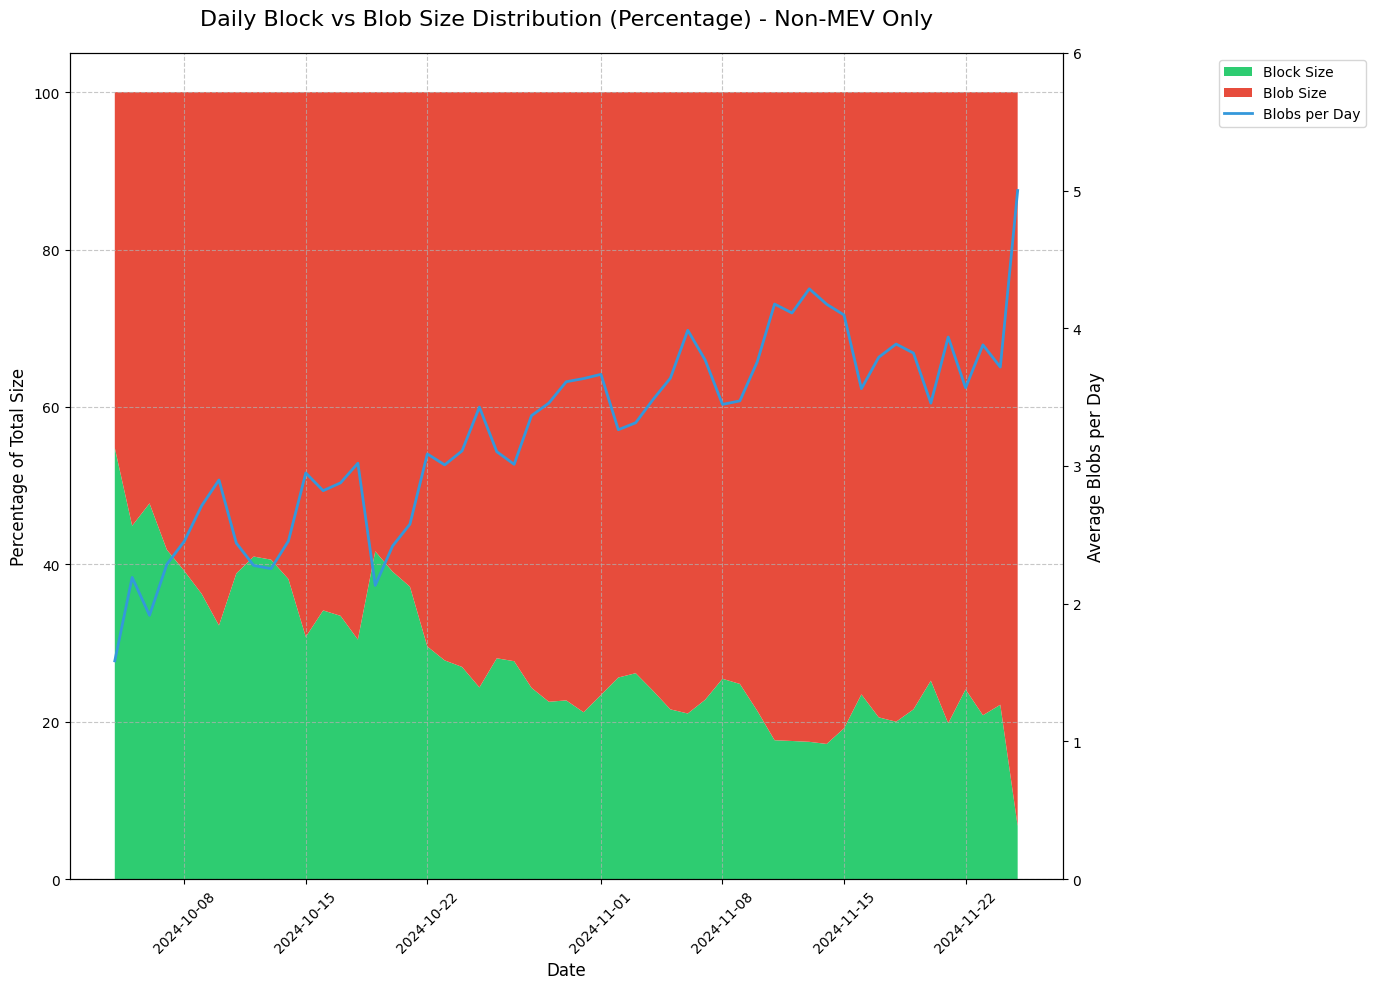

In [17]:
# Filter for non-MEV slots
non_mev_data = combined_data[~combined_data['via_mev']]

# Calculate percentages
non_mev_data['block_pct'] = non_mev_data['block_total_bytes_compressed'] / non_mev_data['total_data_per_slot'] * 100
non_mev_data['blob_pct'] = non_mev_data['total_blob_size'] / non_mev_data['total_data_per_slot'] * 100

# Convert time to date
non_mev_data['date'] = pd.to_datetime(non_mev_data['time']).dt.date

# Calculate daily averages
daily_block_pct = non_mev_data.groupby('date')['block_pct'].mean()
daily_blob_pct = non_mev_data.groupby('date')['blob_pct'].mean()
daily_blobs = non_mev_data.groupby('date')['num_blobs'].mean()

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 10))
ax2 = ax1.twinx()

# Plot stacked area on left axis
ax1.stackplot(daily_block_pct.index, 
              [daily_block_pct.values, daily_blob_pct.values],
              labels=['Block Size', 'Blob Size'],
              colors=['#2ecc71', '#e74c3c'])

# Plot blobs per day on right axis
ax2.plot(daily_blobs.index, daily_blobs.values, color='#3498db', label='Blobs per Day', linewidth=2)

ax1.set_title('Daily Block vs Blob Size Distribution (Percentage) - Non-MEV Only', pad=20, fontsize=16)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Percentage of Total Size', fontsize=12)
ax2.set_ylabel('Average Blobs per Day', fontsize=12)
ax2.set_ylim(0, 6)  # Set y-axis limits for blobs per day

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.15, 1), loc='upper left')

ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_88498/1452959493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mev_slots_with_sizes['date'] = pd.to_datetime(mev_slots_with_sizes['time']).dt.date
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_88498/1452959493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_mev_slots_with_sizes['date'] = pd.to_datetime(non_mev_slots_with_sizes['time']).dt.date


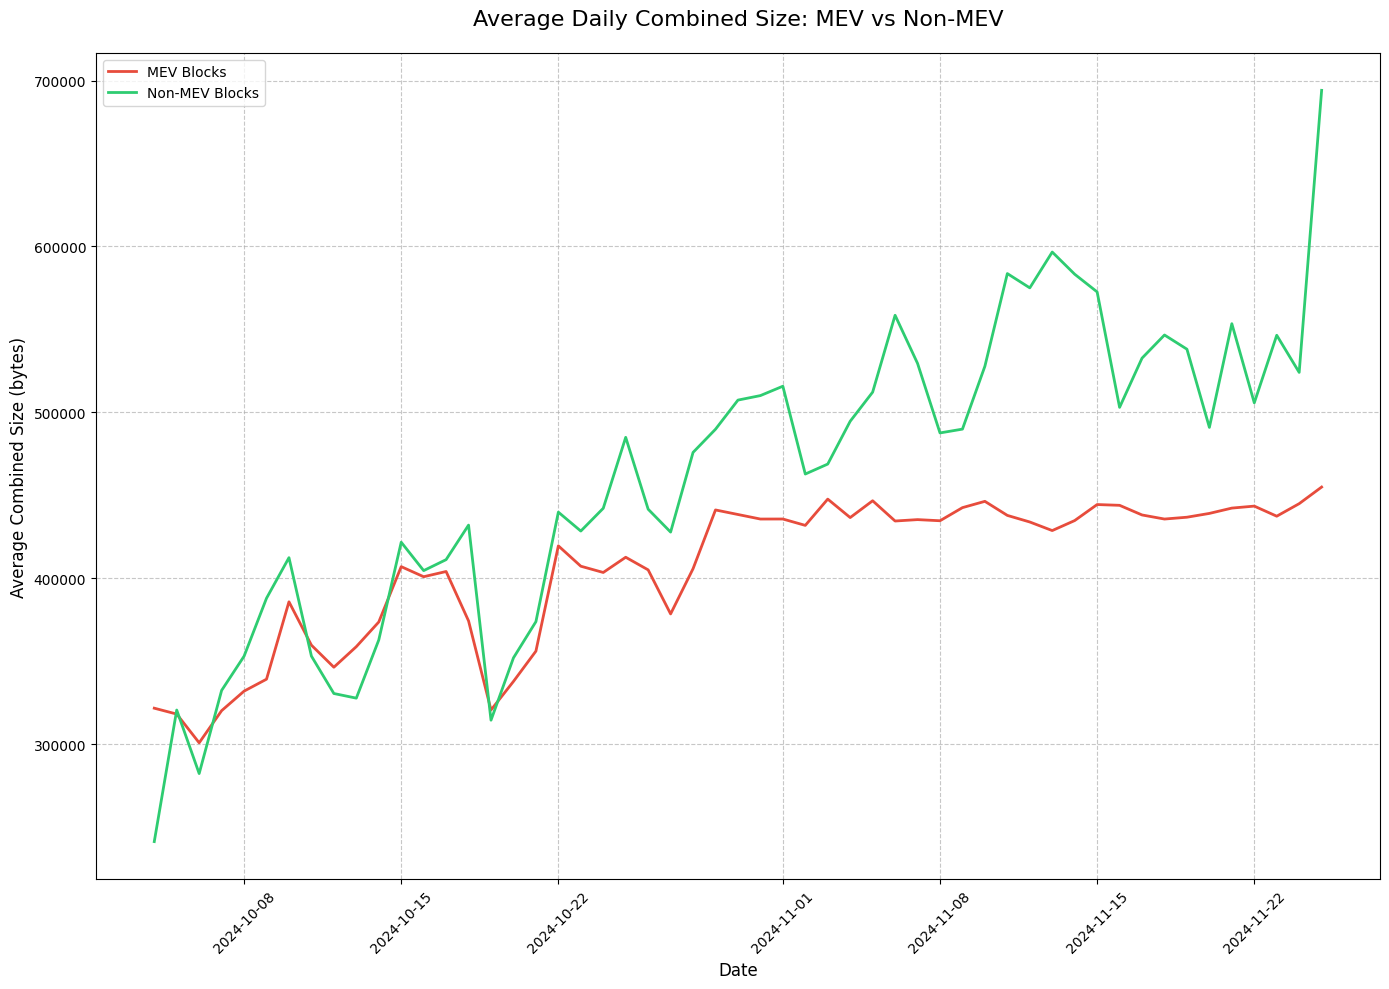

In [18]:
# Convert slot to datetime and extract date
mev_slots_with_sizes['date'] = pd.to_datetime(mev_slots_with_sizes['time']).dt.date
non_mev_slots_with_sizes['date'] = pd.to_datetime(non_mev_slots_with_sizes['time']).dt.date

# Calculate daily averages using combined size
mev_daily_avg = mev_slots_with_sizes.groupby('date')['total_data_per_slot'].mean()
non_mev_daily_avg = non_mev_slots_with_sizes.groupby('date')['total_data_per_slot'].mean()

# Create figure
plt.figure(figsize=(14, 10))

# Plot daily averages
plt.plot(mev_daily_avg.index, mev_daily_avg.values, color='#e74c3c', label='MEV Blocks', linewidth=2)
plt.plot(non_mev_daily_avg.index, non_mev_daily_avg.values, color='#2ecc71', label='Non-MEV Blocks', linewidth=2)

plt.title('Average Daily Combined Size: MEV vs Non-MEV', pad=20, fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Combined Size (bytes)', fontsize=12)
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
query = text("""
    SELECT
        slot_start_date_time as time,
        min(propagation_slot_start_diff) as arrival_time,
        meta_client_geo_country as country,
        slot,
        CASE 
            WHEN meta_client_name NOT LIKE 'ethpandaops%' THEN 'home users'
            ELSE 'ethpandaops'
        END as observed_by_group
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
        AND propagation_slot_start_diff < 6000
    GROUP BY time, country, slot, observed_by_group
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
country_slot_arrival_times = pd.DataFrame(result.fetchall(), columns=['time', 'arrival_time', 'country', 'slot', 'observed_by_group'])

if len(country_slot_arrival_times) == 0:
    raise ValueError("No country arrival times found for the given time range")

print(f"Found {len(country_slot_arrival_times)} country arrival times for the given time range")


Found 3469591 country arrival times for the given time range


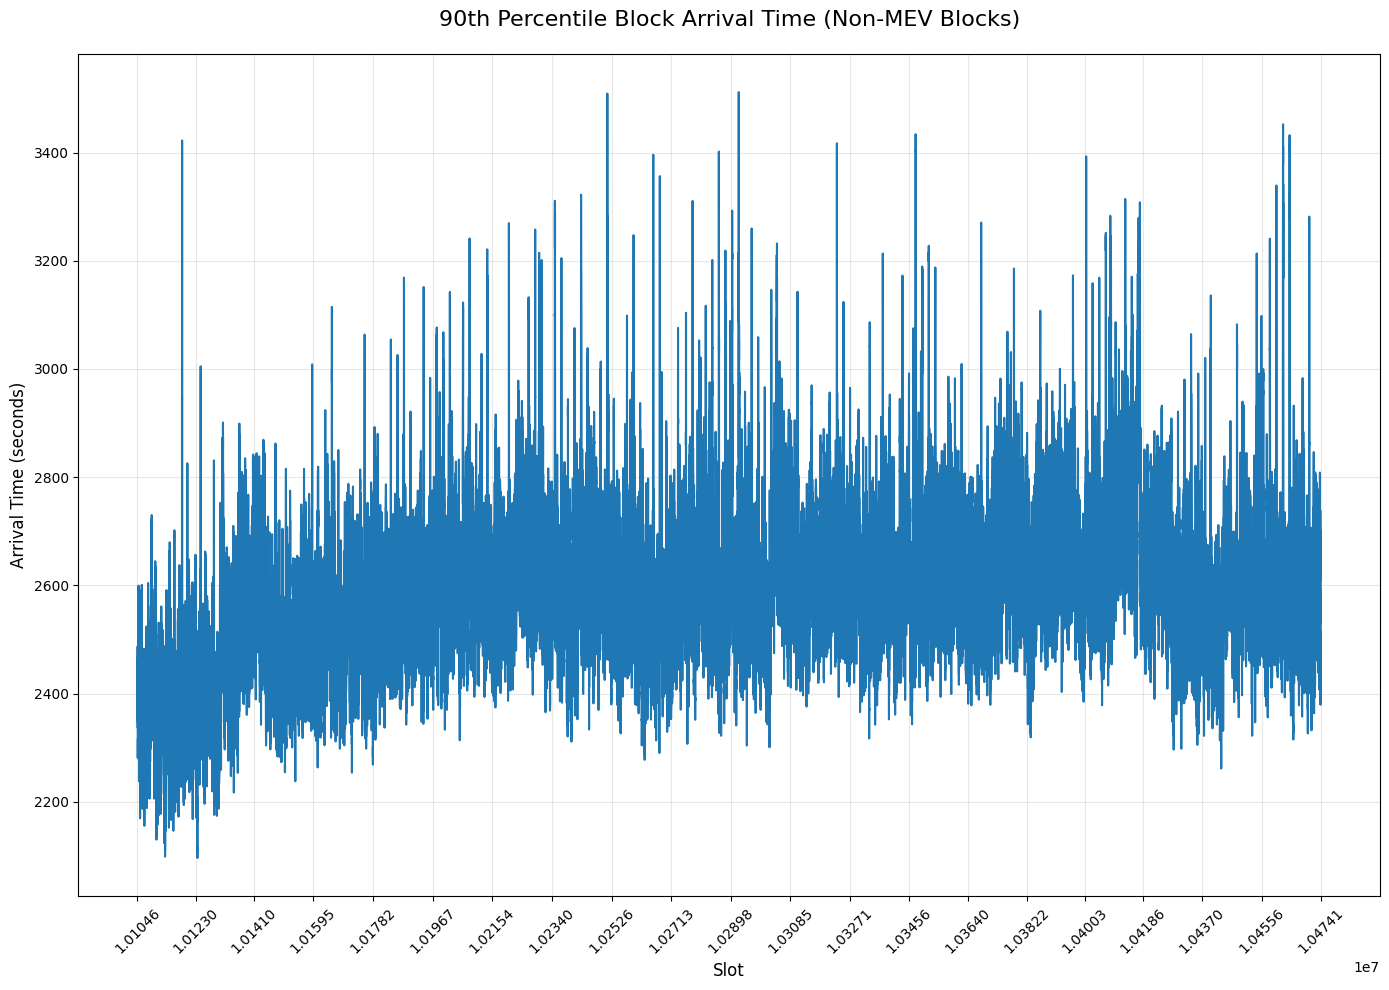

In [29]:
# Create figure
plt.figure(figsize=(14, 10))

# Get p90 arrival time across all countries and smooth with rolling average
pivot_data = country_slot_arrival_times[~country_slot_arrival_times['slot'].isin(non_mev_slots_with_sizes['slot'])].groupby('slot')['arrival_time'].quantile(0.9).reset_index()
pivot_data['arrival_time'] = pivot_data['arrival_time'].rolling(window=50, center=True).mean()

# Create line plot
plt.plot(pivot_data['slot'], pivot_data['arrival_time'])

# Set x-axis ticks
num_slots = len(pivot_data)
skip_slots = max(1, num_slots // 20)
plt.xticks(pivot_data['slot'][::skip_slots], rotation=45)

plt.title('90th Percentile Block Arrival Time (Non-MEV Blocks)', pad=20, fontsize=16)
plt.xlabel('Slot', fontsize=12)
plt.ylabel('Arrival Time (seconds)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [39]:
query = text("""
    SELECT
        slot_start_date_time as time,
        max(propagation_slot_start_diff) as max_arrival_time,
        quantile(0.95)(propagation_slot_start_diff) as p95_arrival_time,
        avg(propagation_slot_start_diff) as avg_arrival_time,
        quantile(0.50)(propagation_slot_start_diff) as p50_arrival_time,
        quantile(0.05)(propagation_slot_start_diff) as p05_arrival_time,
        quantile(0.01)(propagation_slot_start_diff) as p01_arrival_time,
        quantile(0.99)(propagation_slot_start_diff) as p99_arrival_time,
        min(propagation_slot_start_diff) as min_arrival_time,
        slot,
        CASE
            WHEN meta_client_name NOT LIKE 'ethpandaops%' THEN 'home users'
            ELSE 'ethpandaops'
        END as observed_by_group
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
        AND meta_client_name != ''
        AND meta_client_name IS NOT NULL
        AND meta_network_name = 'mainnet'
        AND propagation_slot_start_diff < 6000
    GROUP BY time, slot, observed_by_group
""")

result = connection.execute(query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', '')})
arrival_data = pd.DataFrame(result.fetchall(), columns=[
    'time', 'max_arrival_time', 'p95_arrival_time', 'avg_arrival_time', 'p50_arrival_time', 'p05_arrival_time', 'p01_arrival_time', 'p99_arrival_time', 'min_arrival_time', 'slot', 'observed_by_group'
])

if len(arrival_data) == 0:
    raise ValueError("No aggregated arrival times found for the given time range")

combined_data = pd.merge(combined_data, arrival_data, on=['slot'], how='left')

print(f"Found {len(arrival_data)} aggregated arrival times for the given time range")
print(arrival_data)


Found 735662 aggregated arrival times for the given time range
                      time  max_arrival_time  p95_arrival_time  \
0      2024-11-13 10:29:47              4056           3791.25   
1      2024-10-29 05:51:35              3200           3029.00   
2      2024-11-14 22:49:59              2639           2593.25   
3      2024-10-29 14:41:47              2498           2279.75   
4      2024-10-10 02:08:11              3544           3219.20   
...                    ...               ...               ...   
735657 2024-10-29 10:01:59              2912           2635.75   
735658 2024-10-19 22:34:47              3335           3150.20   
735659 2024-11-18 05:54:23              4184           3308.00   
735660 2024-11-02 12:09:35              4158           4157.20   
735661 2024-11-19 18:13:35              3195           3166.50   

        avg_arrival_time  p50_arrival_time  p05_arrival_time  \
0            2365.312500            2253.5           1721.75   
1            257

In [63]:
worst_case_block_w_eip_7623=0.72

# Calculate p99 block size from data
base_size = combined_data['block_total_bytes_compressed'].quantile(0.99) / 1_000_000  # Convert to MB

block_sizes = [
    {
        'label': 'Historical p99 block size',
        'value': base_size
    },
    # {
    #     'label': 'Worst case with EIP7623',
    #     'value': worst_case_block_w_eip_7623
    # }
]


print(block_sizes)

[{'label': 'Historical p99 block size', 'value': 0.101263}]


In [93]:
entities = combined_data['entity'].value_counts().nlargest(15).index.tolist()

print(entities)

['coinbase', 'solo_stakers', 'ether.fi', 'binance', 'kiln', 'abyss_finance', 'figment', 'kraken', 'rocketpool', 'stakefish', 'staked.us', 'everstake', 'bitcoinsuisse', 'mantle', 'p2porg']


Creating plot for Historical p99 block size with coinbase and observed by home users


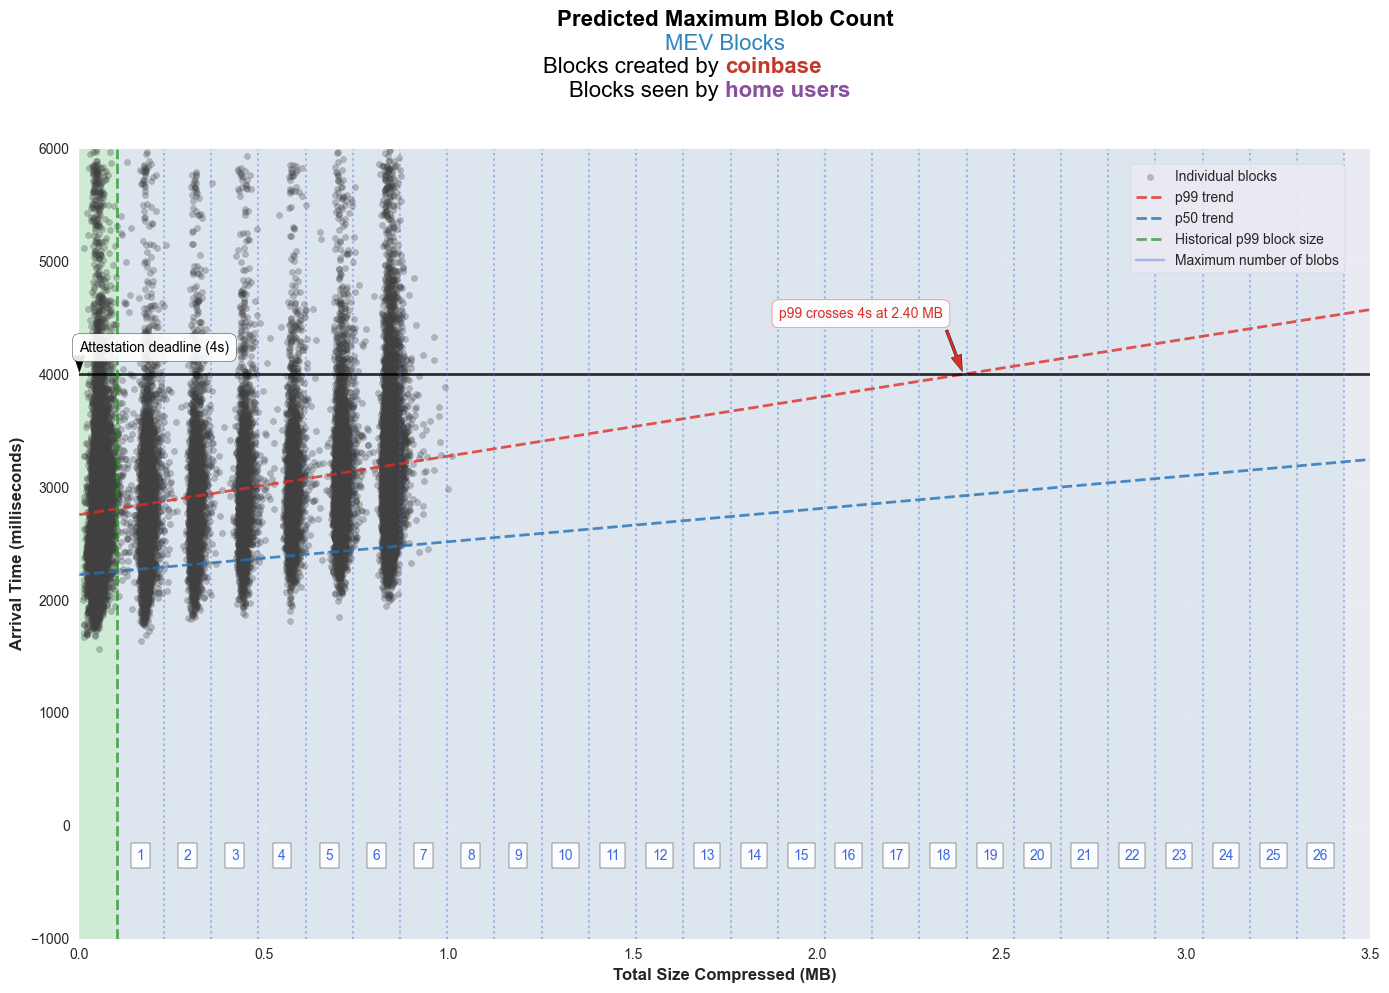

Creating plot for Historical p99 block size with coinbase and observed by ethpandaops
Creating plot for Historical p99 block size with coinbase and observed by all nodes
Creating plot for Historical p99 block size with coinbase and observed by home users
Creating plot for Historical p99 block size with coinbase and observed by ethpandaops
Creating plot for Historical p99 block size with coinbase and observed by all nodes
Creating plot for Historical p99 block size with coinbase and observed by home users
Creating plot for Historical p99 block size with coinbase and observed by ethpandaops
Creating plot for Historical p99 block size with coinbase and observed by all nodes
Creating plot for Historical p99 block size with solo_stakers and observed by home users
Creating plot for Historical p99 block size with solo_stakers and observed by ethpandaops
Creating plot for Historical p99 block size with solo_stakers and observed by all nodes
Creating plot for Historical p99 block size with solo

In [94]:
# Define color map for title parameters
title_param_colors = {
    'mev_status': ['#2E86C1', '#E74C3C', '#27AE60'],  # Colors for MEV/Non-MEV/All
    'entity_colors': ['#8E44AD', '#E67E22', '#16A085', '#2980B9', '#C0392B', '#7D3C98', '#F39C12', '#1ABC9C', '#2E86C1', '#E74C3C', '#27AE60', '#8E44AD', '#D35400', '#16A085', '#2980B9'],  # Colors for different entities
    'observer_colors': ['#884EA0', '#D35400', '#1ABC9C']  # Colors for different observers
}

# Get unique observed_by_groups
observed_by_groups = ['home users', 'ethpandaops', 'all nodes']

# Store figures to combine into gif later
figures = []

# Store trend line data
trend_data = []

# Loop through all combinations
for block_size in block_sizes:
    for entity in entities:
        for is_mev in [True, False, None]:  # None means both
            for observed_by_group in observed_by_groups:
                if observed_by_group == 'nan':
                    continue
                
                print(f"Creating plot for {block_size['label']} with {entity} and observed by {observed_by_group}")
                
                # Filter data based on conditions
                if is_mev is None:
                    slots_df = combined_data
                elif is_mev:
                    slots_df = mev_slots_with_sizes
                else:
                    slots_df = non_mev_slots_with_sizes
                    
                # Merge and filter data
                plot_data = (aggregated_arrival_times
                    .merge(slots_df[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot'))
                
                # Only filter by observed_by_group if not 'all nodes'
                if observed_by_group != 'all nodes':
                    plot_data = plot_data.query(f"observed_by_group == '{observed_by_group}'")
                
                plot_data = plot_data.query(f"entity == '{entity}'")
                
                # Skip if no data after filtering
                if len(plot_data) == 0:
                    print(f"No data for {entity} observed by {observed_by_group}")
                    continue
                    
                # Create figure with style
                plt.style.use('seaborn-v0_8')
                fig = plt.figure(figsize=(14, 10))
                
                plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

                # Plot scatter points
                plt.scatter(plot_data['total_size_mb'], plot_data['p99_arrival_time'], 
                           alpha=0.3, s=20, color='#404040', label='Individual blocks')

                # Add trend lines and annotations for p99 and p50
                metrics = [('p99_arrival_time', '#de2d26', 'p99'), ('p50_arrival_time', '#2171b5', 'p50')]
                max_sizes = []

                for metric, color, label in metrics:
                    z = np.polyfit(plot_data['total_size_mb'], plot_data[metric], 1)
                    p_fit = np.poly1d(z)

                    if z[0] > 0:
                        max_size = (4000 - z[1]) / z[0]
                        max_sizes.append((max_size, entity, is_mev, observed_by_group))
                        x_range = np.linspace(0, 3.5, 100)

                        plt.plot(x_range, p_fit(x_range), '--', color=color, alpha=0.8, linewidth=2, label=f'{label} trend')

                        plt.annotate(
                            f'{label} crosses 4s at {max_size:.2f} MB',
                            xy=(max_size, 4000),
                            xytext=(max_size-0.5, 4500),  # Moved text 0.5 MB to the left
                            arrowprops=dict(
                                facecolor=color,
                                shrink=0.05,
                                width=2,
                                headwidth=8
                            ),
                            color=color,
                            fontsize=10,
                            bbox=dict(facecolor='white', edgecolor=color, alpha=0.9, boxstyle='round,pad=0.5')
                        )
                        
                        # Store trend line data
                        base_size = block_size['value']
                        max_blobs = int((max_size - base_size) / 0.128)
                        trend_data.append({
                            'entity': entity,
                            'is_mev': is_mev,
                            'observed_by': observed_by_group,
                            'metric': label,
                            'max_size_mb': max_size,
                            'max_blobs': max_blobs,
                            'slope': z[0],
                            'intercept': z[1]
                        })

                # Add 4s deadline line
                plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8, linewidth=2, label='Attestation deadline (4s)')

                # Add vertical lines and fill areas
                base_size = block_size['value']
                blob_increment = 0.128

                # Fill block size area
                plt.axvspan(0, base_size, color='#90EE90', alpha=0.3, zorder=0)
                plt.axvline(x=base_size, color='#228B22', linestyle='--', alpha=0.7, linewidth=2, 
                          label=f"{block_size['label']}")

                # Add lines and fill for each blob increment
                for i in range(1, int((3.5 - base_size) / blob_increment) + 1):
                    x_pos = base_size + (i * blob_increment)
                    plt.axvspan(base_size + ((i-1) * blob_increment), x_pos, color='#ADD8E6', alpha=0.2, zorder=0)
                    plt.axvline(x=x_pos, color='#4169E1', linestyle=':', alpha=0.4, linewidth=1.5)
                    plt.text(x_pos - blob_increment/2, -300,
                            str(i),
                            color='#4169E1',
                            alpha=1,
                            fontsize=10,
                            bbox=dict(facecolor='white', alpha=0.9),
                            ha='center')

                # Add "Maximum number of blobs" text to legend
                plt.plot([], [], color='#4169E1', alpha=0.4, label='Maximum number of blobs')

                # Customize plot
                plt.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=10, 
                         bbox_to_anchor=(0.98, 0.98), borderaxespad=0)
                
                mev_text = "MEV Blocks" if is_mev else "Non-MEV Blocks" if is_mev is not None else "All Blocks"
                plt.title(f'Predicted Maximum Blob Count\n'
                         f'{mev_text:}\n'
                         f'Blocks created by {entity}\n'
                         f'Blocks seen by {observed_by_group}',
                         pad=20, fontsize=16,
                         color='black')
                
                # Get consistent colors based on parameter values
                mev_color = title_param_colors['mev_status'][0 if is_mev else 1 if is_mev is not None else 2]
                entity_color = title_param_colors['entity_colors'][hash(entity) % len(title_param_colors['entity_colors'])]
                observer_color = title_param_colors['observer_colors'][hash(observed_by_group) % len(title_param_colors['observer_colors'])]
                
                # Add colored text overlays with consistent colors per value
                ax = plt.gca()
                title = ax.get_title()
                ax.set_title('')  # Clear the title
                lines = title.split('\n')
                y = 1.15  # Starting y position
                plt.text(0.5, y, lines[0], ha='center', va='bottom', transform=ax.transAxes, 
                        fontsize=16, color='black')
                plt.text(0.5, y-0.03, mev_text, ha='center', va='bottom', transform=ax.transAxes,
                        fontsize=16, color=mev_color, fontweight='bold')
                
                # Combine "Created by" and entity on same line
                plt.text(0.5, y-0.06, 'Blocks created by ', ha='right', va='bottom', transform=ax.transAxes,
                        fontsize=16, color='black')
                plt.text(0.5, y-0.06, entity, ha='left', va='bottom', transform=ax.transAxes,
                        fontsize=16, color=entity_color, fontweight='bold')
                
                # Combine "Blocks seen by" and group on same line
                plt.text(0.5, y-0.09, 'Blocks seen by ', ha='right', va='bottom', transform=ax.transAxes,
                        fontsize=16, color='black')
                plt.text(0.5, y-0.09, observed_by_group, ha='left', va='bottom', transform=ax.transAxes,
                        fontsize=16, color=observer_color, fontweight='bold')
                
                plt.xlabel('Total Size Compressed (MB)', fontsize=12, fontweight='bold')
                plt.ylabel('Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
                plt.grid(True, alpha=0.2, linestyle='--')
                plt.ylim(-1000, 6000)  # Extended y-range to accommodate outside labels
                plt.xlim(0, 3.5)
                plt.tight_layout()

                if len(figures) == 0:
                    plt.show()
                
                # Save figure
                if len(max_sizes) > 0:
                    figures.append((max_sizes[0][0], fig))
                plt.close()

# Sort figures by p99 intersection value
figures.sort(key=lambda x: x[0], reverse=True)

# Convert trend data to DataFrame for later use
trend_df = pd.DataFrame(trend_data)

print(trend_df)


In [97]:
# Save as gif
images = [np.asarray(fig.canvas.buffer_rgba()).reshape(fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3] 
          for _, fig in figures]
imageio.mimsave('block_arrival_trends.gif', images, duration=500)



Worst/Best case supported blobs by entity:
               min  max
entity                 
abyss_finance    8   55
binance          7   52
bitcoinsuisse    4  246
coinbase         3   46
ether.fi         2   61
everstake        2   32
figment          6   36
kiln            -3   15
kraken           8  184
mantle           2   28
p2porg           3   43
rocketpool       7   37
solo_stakers     7   50
staked.us        7   50
stakefish        2   45


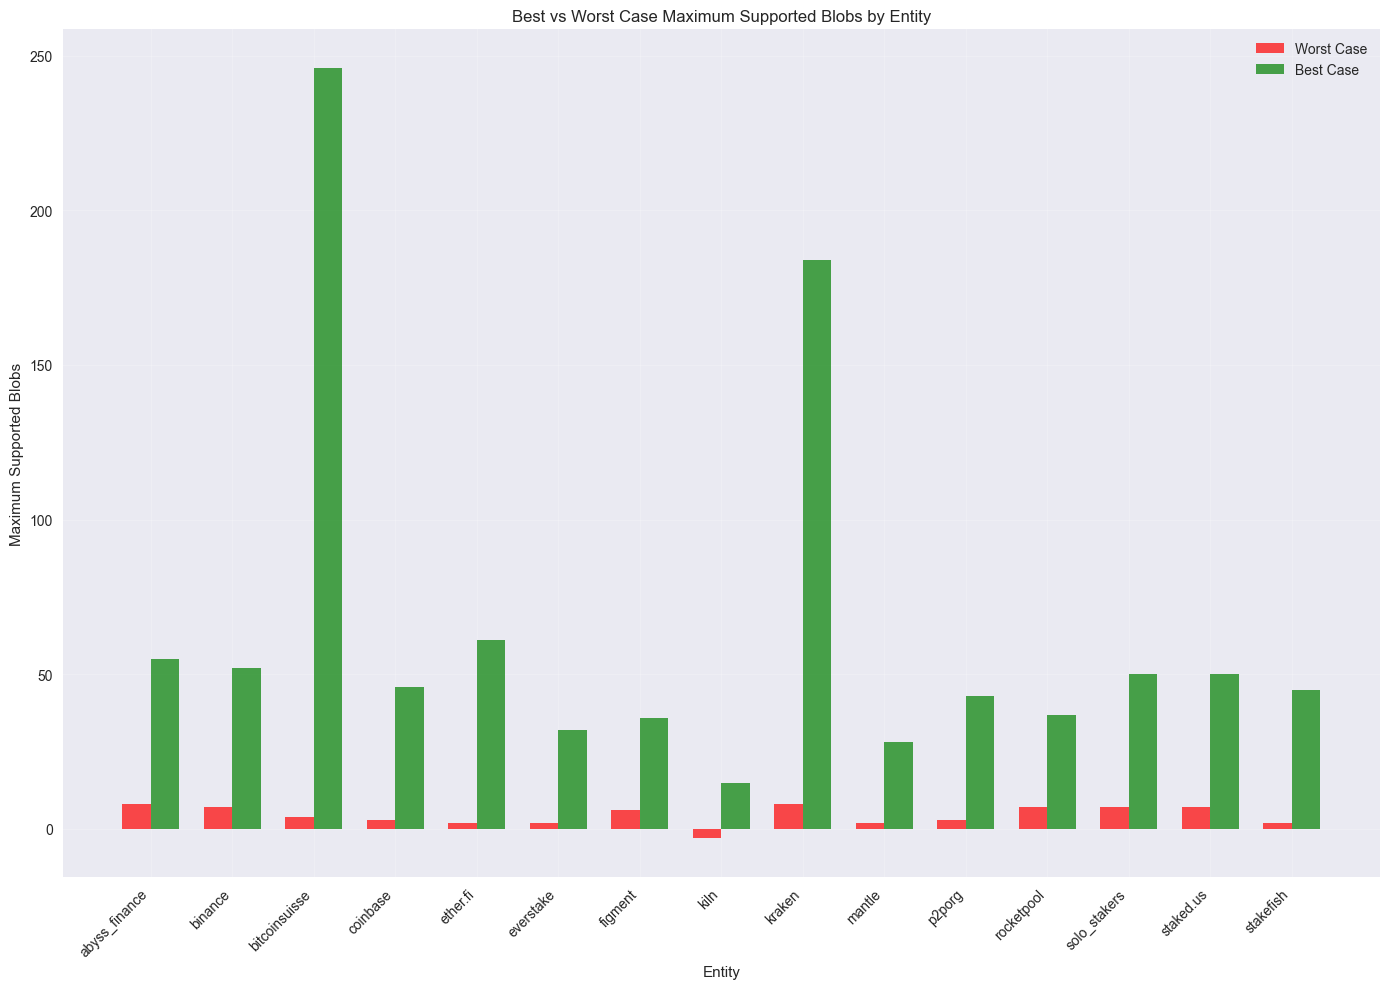

In [96]:
# Get min and max supported blobs for each entity
summary = trend_df.groupby('entity')['max_blobs'].agg(['min', 'max']).round(1)
print("\nWorst/Best case supported blobs by entity:")
print(summary)

# Create bar plot
plt.figure(figsize=(14, 10))

entities = summary.index
x = np.arange(len(entities))
width = 0.35

# Plot min/max bars
plt.bar(x - width/2, summary['min'], width, label='Worst Case', color='red', alpha=0.7)
plt.bar(x + width/2, summary['max'], width, label='Best Case', color='green', alpha=0.7)

plt.xlabel('Entity')
plt.ylabel('Maximum Supported Blobs')
plt.title('Best vs Worst Case Maximum Supported Blobs by Entity')
plt.xticks(x, entities, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


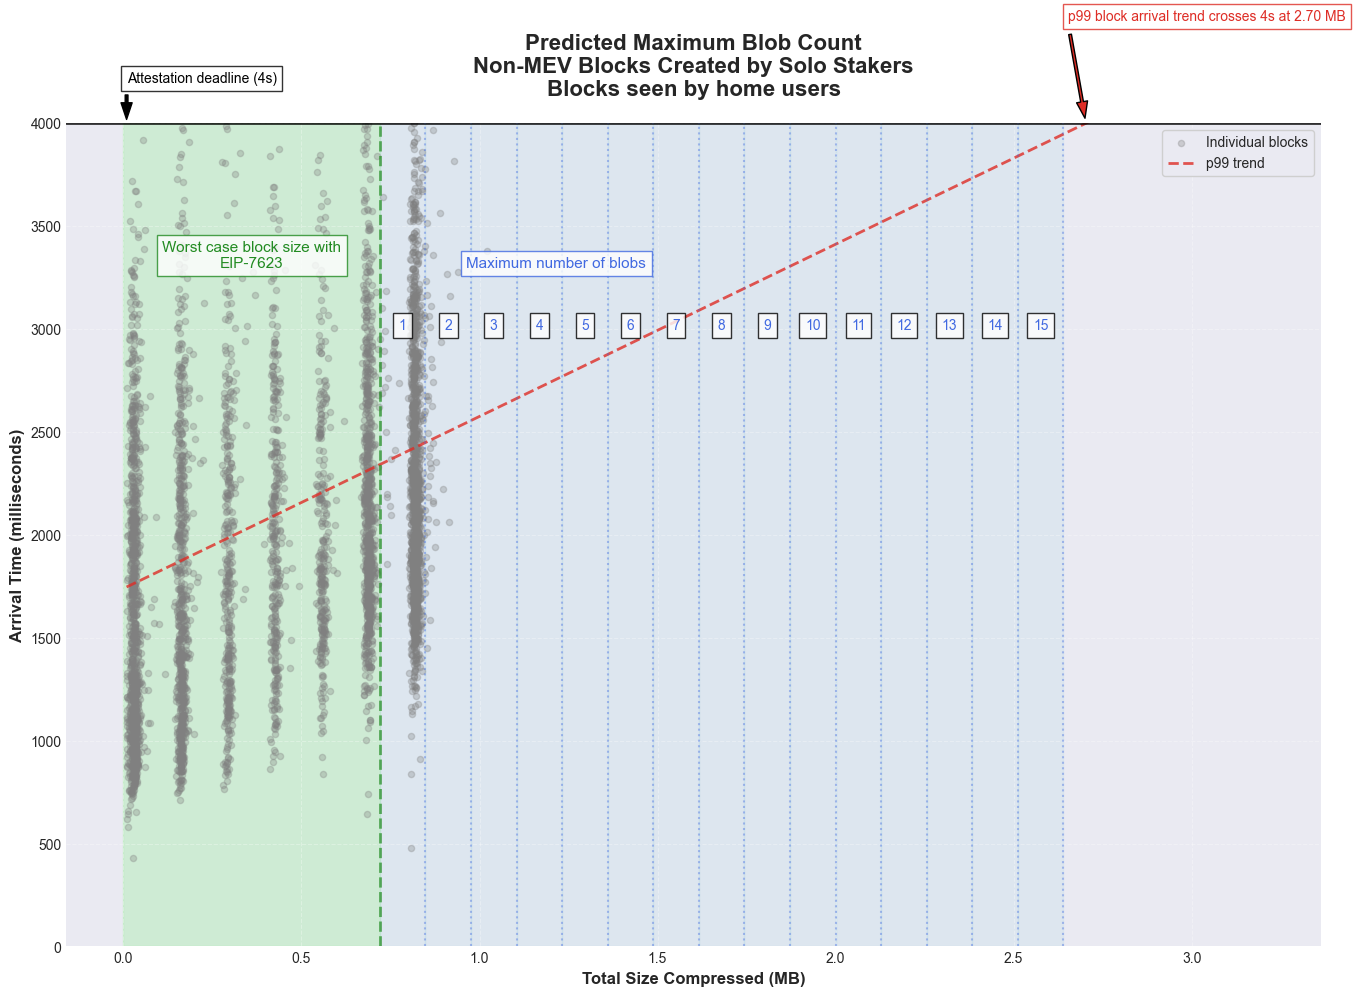

In [38]:
# Create figure with larger size for better visibility
plt.figure(figsize=(14, 10))

# Prepare data
plot_data = (aggregated_arrival_times
    .merge(non_mev_slots_with_sizes[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot')
    .query("entity == 'solo_stakers'"))
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Plot scatter points
plt.scatter(plot_data['total_size_mb'], plot_data['p99_arrival_time'], 
           alpha=0.3, s=20, color='gray', label='Individual blocks')

# Add trend line and annotation
metric = 'p99_arrival_time'
color = '#de2d26'  # Red
label = 'p99'

# Calculate trend line
z = np.polyfit(plot_data['total_size_mb'], plot_data[metric], 1)
p_fit = np.poly1d(z)

# Find intersection with 4s deadline
max_size = (4000 - z[1]) / z[0]
x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)

# Plot trend line
plt.plot(x_range, p_fit(x_range), '--', color=color, alpha=0.8, linewidth=2, label=f'{label} trend')

# Add annotation
plt.annotate(
    f'{label} block arrival trend crosses 4s at {max_size:.2f} MB',
    xy=(max_size, 4000),
    xytext=(max_size-0.05, 4500),
    arrowprops=dict(
        facecolor=color,
        shrink=0.05,
        width=2,
        headwidth=8
    ),
    color=color,
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor=color, alpha=0.8)
)

# Add 4s deadline line
plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8, linewidth=2)
plt.annotate(
    'Attestation deadline (4s)', 
    xy=(plot_data['total_size_mb'].min(), 4000),
    xytext=(plot_data['total_size_mb'].min(), 4200),
    arrowprops=dict(
        facecolor='black',
        shrink=0.1,
        width=2,
        headwidth=8
    ),
    color='black',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# Add vertical lines and fill areas
base_size = 0.72  # Initial line at 0.72 MB
blob_increment = 0.128  # 128kb = 0.128 MB

# Fill block size area
plt.axvspan(0, base_size, color='#90EE90', alpha=0.3, zorder=0)  # Lighter green
plt.axvline(x=base_size, color='#228B22', linestyle='--', alpha=0.7, linewidth=2)  # Darker green
plt.text(base_size/2, 3300,
         'Worst case block size with\nEIP-7623',
         color='#228B22',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#228B22', alpha=0.8),
         ha='center')

# Add lines and fill for each blob increment
for i in range(1, int((max_size - base_size) / blob_increment) + 1):
    x_pos = base_size + (i * blob_increment)
    plt.axvspan(base_size + ((i-1) * blob_increment), x_pos, color='#ADD8E6', alpha=0.2, zorder=0)
    plt.axvline(x=x_pos, color='#4169E1', linestyle=':', alpha=0.4, linewidth=1.5)
    plt.text(x_pos - blob_increment/2, 3000,
             str(i),
             color='#4169E1',
             alpha=1,
             fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8),
             ha='center')

# Add "blob number" text in the middle
plt.text(base_size + (max_size - base_size)/4, 3300,
         'Maximum number of blobs',
         color='#4169E1',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
         ha='center')

# Customize plot
plt.legend(frameon=True, framealpha=0.9, fontsize=10)
plt.title('Predicted Maximum Blob Count\nNon-MEV Blocks Created by Solo Stakers\nBlocks seen by home users', 
         pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Total Size Compressed (MB)', fontsize=12, fontweight='bold')
plt.ylabel('Arrival Time (milliseconds)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0, 4000)
plt.tight_layout()
plt.show()


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_47670/827242615.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_per_bin = plot_data.groupby(size_bins)[metric].quantile(percentile)
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_47670/827242615.py:28: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  bin_centers = size_bins.unique().map(lambda x: x.mid).sort_values()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_47670/827242615.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False t

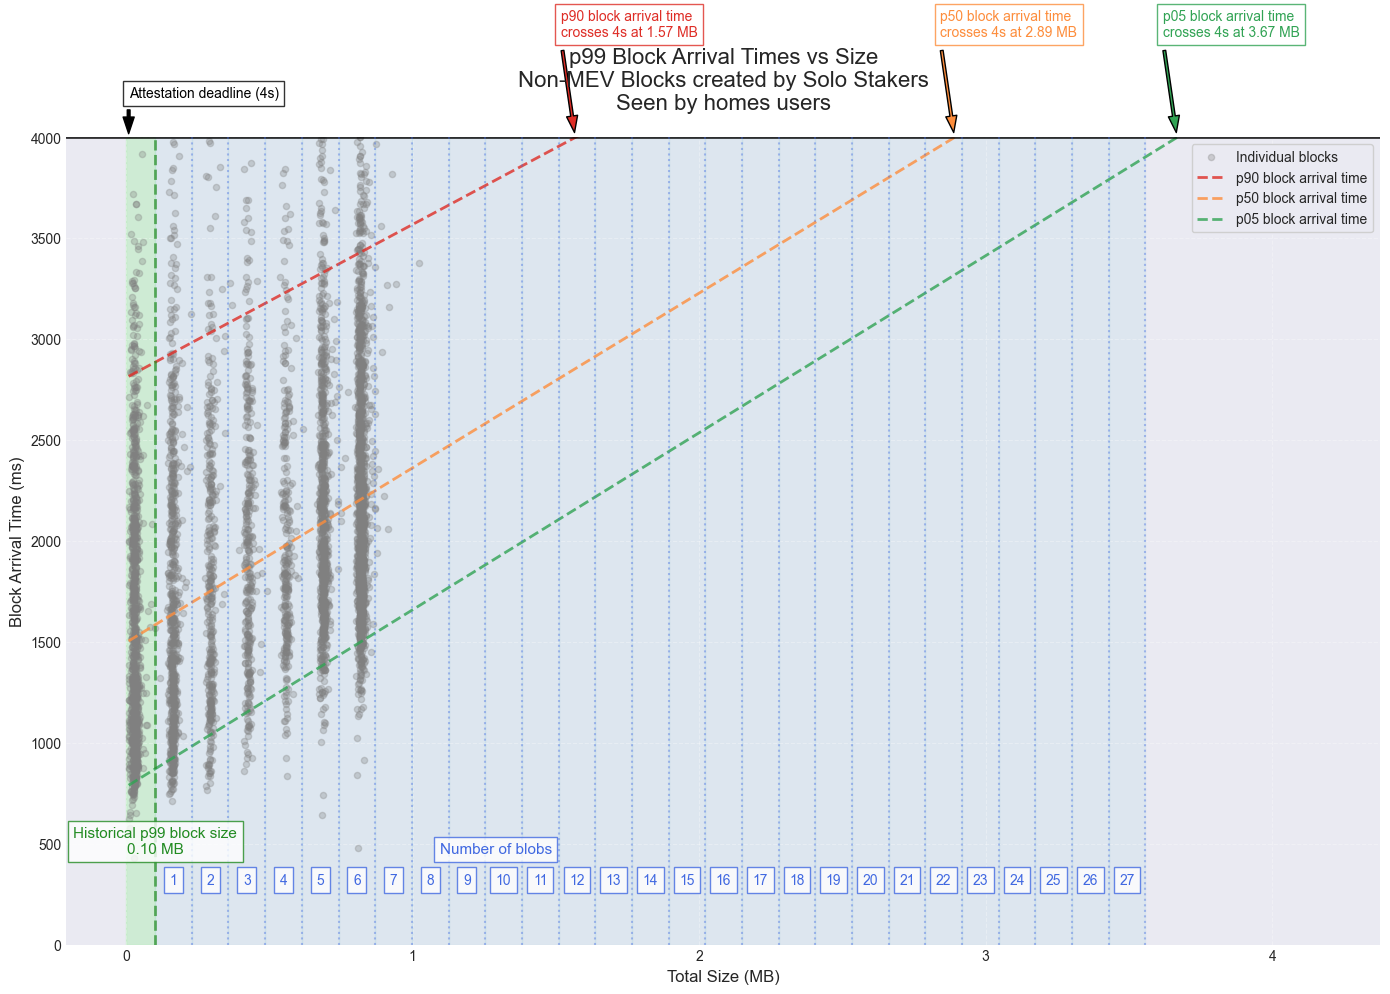

In [39]:


# Create figure with larger size for better visibility
plt.figure(figsize=(14, 10))

# Prepare data
plot_data = (aggregated_arrival_times
    .merge(non_mev_slots_with_sizes[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot')
    .query("entity == 'solo_stakers'"))
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Plot scatter points
plt.scatter(plot_data['total_size_mb'], plot_data['p99_arrival_time'], 
           alpha=0.3, s=20, color='gray', label='Individual blocks')

# Add trend lines and annotations
metric = 'p99_arrival_time'
percentiles = [(0.90, '#de2d26', 'p90 block arrival time'), 
              (0.50, '#fd8d3c', 'p50 block arrival time'),
              (0.05, '#31a354', 'p05 block arrival time')]

max_sizes = []
for percentile, color, label in percentiles:
    # Calculate trend line using percentile of p99 arrival times
    size_bins = pd.qcut(plot_data['total_size_mb'], q=20)
    p_per_bin = plot_data.groupby(size_bins)[metric].quantile(percentile)
    bin_centers = size_bins.unique().map(lambda x: x.mid).sort_values()

    # Calculate trend line
    z = np.polyfit(bin_centers, p_per_bin, 1)
    p_fit = np.poly1d(z)

    # Find intersection with 4s deadline
    max_size = (4000 - z[1]) / z[0]
    max_sizes.append(max_size)
    x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)

    # Plot trend line
    plt.plot(x_range, p_fit(x_range), '--', color=color, alpha=0.8, linewidth=2, label=label)

    # Add annotation
    plt.annotate(
        f'{label}\ncrosses 4s at {max_size:.2f} MB',
        xy=(max_size, 4000),
        xytext=(max_size-0.05, 4500),
        arrowprops=dict(
            facecolor=color,
            shrink=0.05,
            width=2,
            headwidth=8
        ),
        color=color,
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor=color, alpha=0.8)
    )

# Add 4s deadline line
plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8, linewidth=2)
plt.annotate(
    'Attestation deadline (4s)', 
    xy=(plot_data['total_size_mb'].min(), 4000),
    xytext=(plot_data['total_size_mb'].min(), 4200),
    arrowprops=dict(
        facecolor='black',
        shrink=0.1,
        width=2,
        headwidth=8
    ),
    color='black',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# Add vertical lines and fill areas
blob_increment = 0.128  # 128kb = 0.128 MB

# Fill block size area
plt.axvspan(0, base_size, color='#90EE90', alpha=0.3, zorder=0)  # Lighter green
plt.axvline(x=base_size, color='#228B22', linestyle='--', alpha=0.7, linewidth=2)  # Darker green
plt.text(base_size, 450,
         f'Historical p99 block size\n{base_size:.2f} MB',
         color='#228B22',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#228B22', alpha=0.8),
         ha='center')

# Use max_size from p05 (most optimistic case) for blob lines
max_size = max_sizes[2]

# Add lines and fill for each blob increment
for i in range(1, int((max_size - base_size) / blob_increment) + 1):
    x_pos = base_size + (i * blob_increment)
    plt.axvspan(base_size + ((i-1) * blob_increment), x_pos, color='#ADD8E6', alpha=0.2, zorder=0)
    plt.axvline(x=x_pos, color='#4169E1', linestyle=':', alpha=0.4, linewidth=1.5)
    plt.text(x_pos - blob_increment/2, 300,
             str(i),
             color='#4169E1',
             alpha=1,
             fontsize=10,
             bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
             ha='center')

# Add "blob number" text in the middle
plt.text(base_size + (max_size - base_size)/3, 450,
         'Number of blobs',
         color='#4169E1',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
         ha='center')

# Customize plot
plt.legend(frameon=True, framealpha=0.9, fontsize=10)
plt.title('p99 Block Arrival Times vs Size\nNon-MEV Blocks created by Solo Stakers\nSeen by home users', 
         pad=20, fontsize=16)
plt.xlabel('Total Size (MB)', fontsize=12)
plt.ylabel('Block Arrival Time (ms)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0, 4000)
plt.tight_layout()
plt.show()


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_47670/1164434658.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_per_bin = plot_data.groupby(size_bins)[metric].quantile(percentile)
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_47670/1164434658.py:28: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  bin_centers = size_bins.unique().map(lambda x: x.mid).sort_values()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_47670/1164434658.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

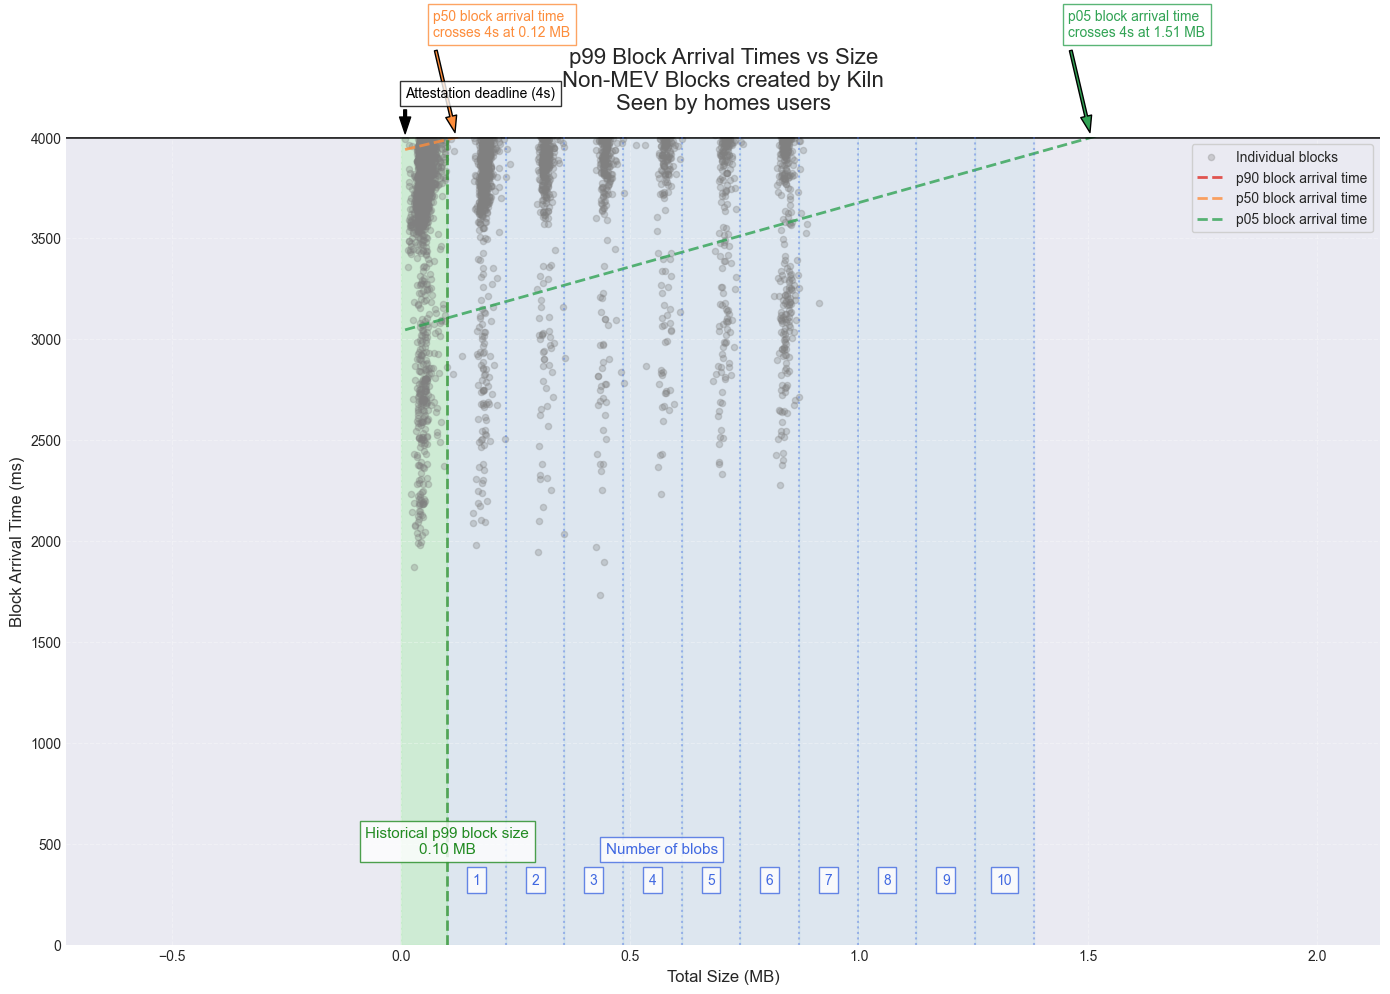

In [40]:
# Calculate p99 block size from data
base_size = combined_data['block_total_bytes_compressed'].quantile(0.99) / 1_000_000  # Convert to MB

# Create figure with larger size for better visibility
plt.figure(figsize=(14, 10))

# Prepare data
plot_data = (aggregated_arrival_times
    .merge(combined_data[['slot', 'block_total_bytes_compressed', 'total_blob_size', 'entity']], on='slot')
    .query("entity == 'kiln'"))
plot_data['total_size_mb'] = (plot_data['block_total_bytes_compressed'] + plot_data['total_blob_size']) / 1_000_000

# Plot scatter points
plt.scatter(plot_data['total_size_mb'], plot_data['p99_arrival_time'], 
           alpha=0.3, s=20, color='gray', label='Individual blocks')

# Add trend lines and annotations
metric = 'p99_arrival_time'
percentiles = [(0.90, '#de2d26', 'p90 block arrival time'), 
              (0.50, '#fd8d3c', 'p50 block arrival time'),
              (0.05, '#31a354', 'p05 block arrival time')]

max_sizes = []
for percentile, color, label in percentiles:
    # Calculate trend line using percentile of p99 arrival times
    size_bins = pd.qcut(plot_data['total_size_mb'], q=20)
    p_per_bin = plot_data.groupby(size_bins)[metric].quantile(percentile)
    bin_centers = size_bins.unique().map(lambda x: x.mid).sort_values()

    # Calculate trend line
    z = np.polyfit(bin_centers, p_per_bin, 1)
    p_fit = np.poly1d(z)

    # Find intersection with 4s deadline
    max_size = (4000 - z[1]) / z[0]
    max_sizes.append(max_size)
    x_range = np.linspace(plot_data['total_size_mb'].min(), max_size + 0.5, 100)

    # Plot trend line
    plt.plot(x_range, p_fit(x_range), '--', color=color, alpha=0.8, linewidth=2, label=label)

    # Add annotation
    plt.annotate(
        f'{label}\ncrosses 4s at {max_size:.2f} MB',
        xy=(max_size, 4000),
        xytext=(max_size-0.05, 4500),
        arrowprops=dict(
            facecolor=color,
            shrink=0.05,
            width=2,
            headwidth=8
        ),
        color=color,
        fontsize=10,
        bbox=dict(facecolor='white', edgecolor=color, alpha=0.8)
    )

# Add 4s deadline line
plt.axhline(y=4000, color='black', linestyle='-', alpha=0.8, linewidth=2)
plt.annotate(
    'Attestation deadline (4s)', 
    xy=(plot_data['total_size_mb'].min(), 4000),
    xytext=(plot_data['total_size_mb'].min(), 4200),
    arrowprops=dict(
        facecolor='black',
        shrink=0.1,
        width=2,
        headwidth=8
    ),
    color='black',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.8)
)

# Add vertical lines and fill areas
blob_increment = 0.128  # 128kb = 0.128 MB

# Fill block size area
plt.axvspan(0, base_size, color='#90EE90', alpha=0.3, zorder=0)  # Lighter green
plt.axvline(x=base_size, color='#228B22', linestyle='--', alpha=0.7, linewidth=2)  # Darker green
plt.text(base_size, 450,
         f'Historical p99 block size\n{base_size:.2f} MB',
         color='#228B22',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#228B22', alpha=0.8),
         ha='center')

# Use max_size from p05 (most optimistic case) for blob lines
max_size = max_sizes[2]

# Add lines and fill for each blob increment
for i in range(1, int((max_size - base_size) / blob_increment) + 1):
    x_pos = base_size + (i * blob_increment)
    plt.axvspan(base_size + ((i-1) * blob_increment), x_pos, color='#ADD8E6', alpha=0.2, zorder=0)
    plt.axvline(x=x_pos, color='#4169E1', linestyle=':', alpha=0.4, linewidth=1.5)
    plt.text(x_pos - blob_increment/2, 300,
             str(i),
             color='#4169E1',
             alpha=1,
             fontsize=10,
             bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
             ha='center')

# Add "blob number" text in the middle
plt.text(base_size + (max_size - base_size)/3, 450,
         'Number of blobs',
         color='#4169E1',
         alpha=1,
         fontsize=11,
         bbox=dict(facecolor='white', edgecolor='#4169E1', alpha=0.8),
         ha='center')

# Customize plot
plt.legend(frameon=True, framealpha=0.9, fontsize=10)
plt.title('p99 Block Arrival Times vs Size\nNon-MEV Blocks created by Kiln\nSeen by homes users', 
         pad=20, fontsize=16)
plt.xlabel('Total Size (MB)', fontsize=12)
plt.ylabel('Block Arrival Time (ms)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(0, 4000)
plt.tight_layout()
plt.show()
